<a href="https://colab.research.google.com/github/basedsaksham/Enhancing-table-parsing/blob/main/hindi_table_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
!pip install -q timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 43.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 618.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

# Download a file from the specified Hugging Face repository and location
file_path = hf_hub_download(repo_id="nielsr/example-pdf", repo_type="dataset", filename="example_table.png")

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 50% of its original dimensions
resized_image = image.resize((int(width * 0.5), int(height * 0.5)))

In [ ]:
from transformers import DetrFeatureExtractor

# Create an instance of the DetrFeatureExtractor
feature_extractor = DetrFeatureExtractor()

# Use the feature extractor to encode the image
# 'image' should be the PIL image object that was obtained earlier
encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

/usr/local/lib/python3.10/dist-packages/transformers/models/detr/feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [ ]:
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for object detection
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-detection")

Some weights of the model checkpoint at microsoft/table-transformer-detection were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import torch

# Disable gradient computation for inference
with torch.no_grad():
    # Pass the encoded image through the model for inference
    # 'model' is the TableTransformerForObjectDetection model loaded previously
    # 'encoding' contains the encoded image features obtained using the DetrFeatureExtractor
    outputs = model(**encoding)

In [ ]:
import matplotlib.pyplot as plt

# Define colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    # Create a figure for visualization
    plt.figure(figsize=(16, 10))

    # Display the PIL image
    plt.imshow(pil_img)

    # Get the current axis
    ax = plt.gca()

    # Repeat the COLORS list multiple times for visualization
    colors = COLORS * 100

    # Iterate through scores, labels, boxes, and colors for visualization
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
        # Add a rectangle to the image for the detected object's bounding box
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))

        # Prepare the text for the label and score
        text = f'{model.config.id2label[label]}: {score:0.2f}'

        # Add the label and score text to the image
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))

    # Turn off the axis
    plt.axis('off')

    # Display the visualization
    plt.show()

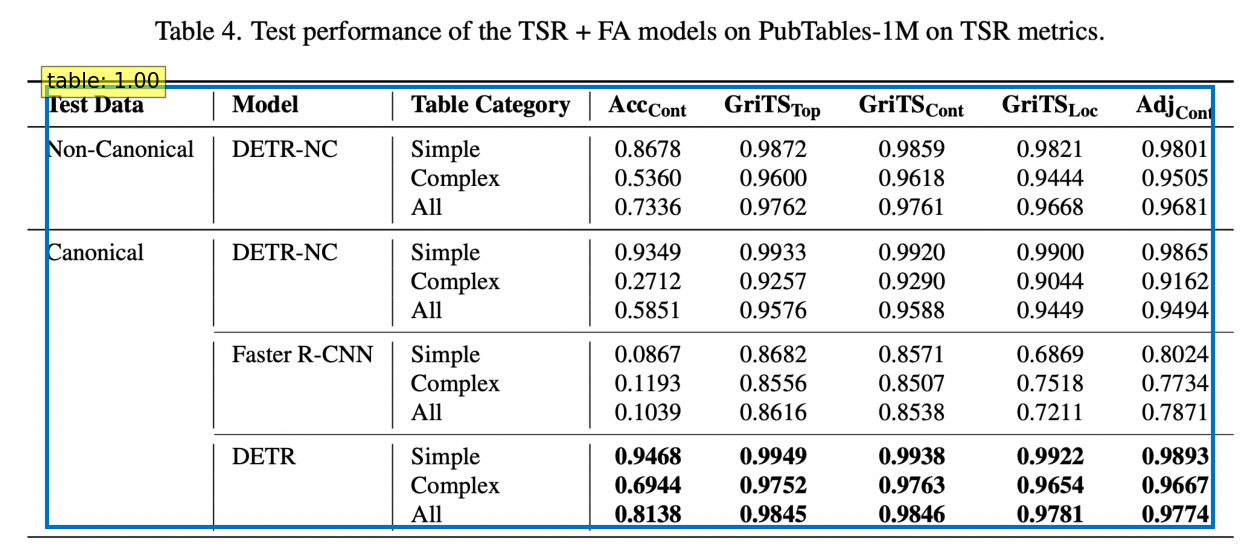

In [ ]:
width, height = image.size

# Post-process the object detection outputs using the feature extractor
results = feature_extractor.post_process_object_detection(outputs, threshold=0.7, target_sizes=[(height, width)])[0]

# Plot the visualization of the results
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
from huggingface_hub import hf_hub_download
from PIL import Image

# Download the image file from the specified Hugging Face repository and location
# Use either of the provided 'repo_id' lines depending on your use case
file_path ="/content/table2.JPG"
# file_path = hf_hub_download(repo_id="inuwamobarak/random-files", repo_type="dataset", filename="Screenshot from 2023-08-16 22-40-10.png")

# Open the downloaded image using the PIL library and convert it to RGB format
image = Image.open(file_path).convert("RGB")

# Get the original width and height of the image
width, height = image.size

# Resize the image to 90% of its original dimensions
resized_image = image.resize((int(width * 0.9), int(height * 0.9)))

In [ ]:
resized_image.show

<bound method Image.show of <PIL.Image.Image image mode=RGB size=939x512 at 0x7E4452DAC6D0>>

In [ ]:
encoding = feature_extractor(image, return_tensors="pt")

# Get the keys of the encoding dictionary
keys = encoding.keys()

In [ ]:
from transformers import TableTransformerForObjectDetection

# Load the pre-trained Table Transformer model for table structure recognition
model = TableTransformerForObjectDetection.from_pretrained("microsoft/table-transformer-structure-recognition")

with torch.no_grad():
  outputs = model(**encoding)

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


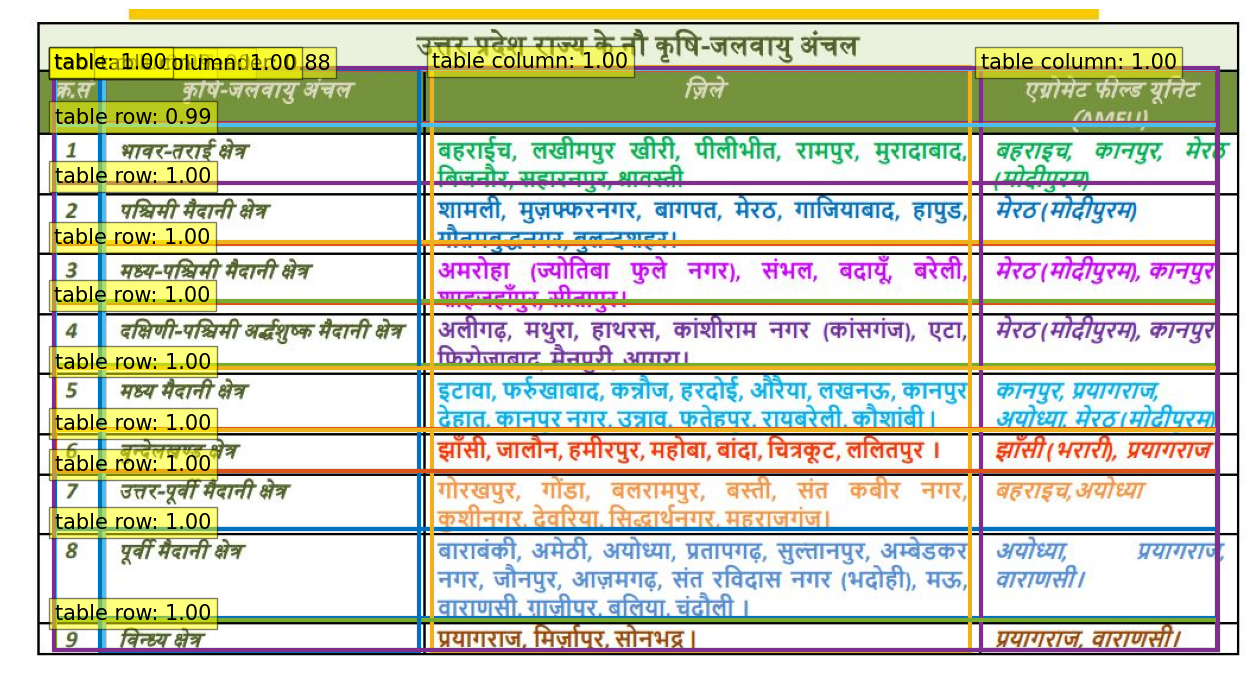

In [ ]:
target_sizes = [image.size[::-1]]

# Post-process the object detection outputs using the feature extractor
# Use a threshold of 0.6 for confidence
results = feature_extractor.post_process_object_detection(outputs, threshold=0.6, target_sizes=target_sizes)[0]

plot_results(image, results['scores'], results['labels'], results['boxes'])

In [ ]:
!pip install pytesseract
!sudo apt install tesseract-ocr

!sudo apt-get install -y tesseract-ocr-script-deva

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr-script-deva is already the newest version (1:4.00~git30-7274cfa-1.1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:

import pytesseract
import PIL.Image
import cv2
from pytesseract import Output
!export TESSDATA_PREFIX=/usr/share/tesseract-ocr/4.00/tessdata
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'


In [ ]:

# Read the image using PyTesseract
text = pytesseract.image_to_string(image, config='--psm 6', lang='Devanagari')

# Split the text into lines
lines = text.split('\n')

# Create a list to store the words in each row
rows = []

# Iterate over each line
for line in lines:
    # Split the line into words
    words = line.split()

    # Append the words to the rows list
    rows.append(words)

# Print the words in each row
for row in rows:
    print(row)


['TTT']
['उत्तर', 'प्रदेश', 'राज्य', 'के', 'नौ', 'कृषि-जलवायु', 'अंचल']
['CD]']
['|']
['बिजनौर,', 'सहारनपुर,', 'श्रावस्ती', '(मोढीपृरम्\u200c']
['[|']
['मबुद्धनगर,', 'बुलन्दशहर।']
['|']
['_']
['फिरोजाबाद,', 'मैनपुरी,', 'आगरा।']
['देहात,', 'कानपुर', 'नगर,', 'उन्नाव,', 'फतेहपुर,', 'रायबरेली,', 'कौशांबी', '|', 'अयोध्या', 'मेरठ(मोढीपुरम']
['कुशीनगर,', 'देवरिया,', 'सिद्धार्थनगर,', 'महराजगंज।']
['र्वी', 'मैदानी', 'क्षेत्र', 'बाराबंकी,', 'अमेठी,', 'अयोध्या,', 'प्रतापगढ़,', 'सुल्तानपुर,', 'अम्बेडकर', '|', 'अयोध्या,', 'प्रयायराज']
['ः']
['वाराणसी,', 'गाज़ीपुर,', 'बलिया,', 'चंदौली', '।']
[]


In [ ]:


import csv

# Create a CSV file to store the table data
with open('table_data.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header row
    writer.writerow(['Column 1', 'Column 2', 'Column 3'])

    # Write the data rows
    for row in rows:
        writer.writerow(row)

# Read the CSV file and print its contents
with open('table_data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        print(row)


['Column 1', 'Column 2', 'Column 3']
['TTT']
['उत्तर', 'प्रदेश', 'राज्य', 'के', 'नौ', 'कृषि-जलवायु', 'अंचल']
['CD]']
['|']
['बिजनौर,', 'सहारनपुर,', 'श्रावस्ती', '(मोढीपृरम्\u200c']
['[|']
['मबुद्धनगर,', 'बुलन्दशहर।']
['|']
['_']
['फिरोजाबाद,', 'मैनपुरी,', 'आगरा।']
['देहात,', 'कानपुर', 'नगर,', 'उन्नाव,', 'फतेहपुर,', 'रायबरेली,', 'कौशांबी', '|', 'अयोध्या', 'मेरठ(मोढीपुरम']
['कुशीनगर,', 'देवरिया,', 'सिद्धार्थनगर,', 'महराजगंज।']
['र्वी', 'मैदानी', 'क्षेत्र', 'बाराबंकी,', 'अमेठी,', 'अयोध्या,', 'प्रतापगढ़,', 'सुल्तानपुर,', 'अम्बेडकर', '|', 'अयोध्या,', 'प्रयायराज']
['ः']
['वाराणसी,', 'गाज़ीपुर,', 'बलिया,', 'चंदौली', '।']
[]
